In [1]:
import os

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
csv_dir = '../my-data'
dfs_1, dfs_2 = [], []
for csv in os.listdir(csv_dir):
    df = pd.read_csv(os.path.join(csv_dir, csv), index_col=0, dtype=float)
    df.drop(columns=["0.5"], inplace=True)
    if csv.endswith('1.csv'):
        dfs_1.append(df)
    elif csv.endswith('2.csv'):
        dfs_2.append(df)

chiller_temps = [pd.concat(dfs) for dfs in zip(dfs_1, dfs_2)]
df_concat = pd.concat(chiller_temps)
df_grouped = df_concat.groupby(df_concat.index)
avg_temp = df_grouped.mean()
avg_temp.drop(index=[30.0, 90.0, 150.0, 210.0, 240.0, 270.0, 300.0, 330.0], inplace=True)
avg_temp.drop(columns=["2.0", "2.75", "3.5", "5.0", "5.75", "6.5"], inplace=True)
avg_temp.head(13)

,1.25,4.25,7.25
0.0,1.360195,3.331275,5.192810
60.0,2.101070,3.340425,4.392805
120.0,1.898960,3.002945,2.513745
180.0,1.661300,2.688655,1.916750


In [4]:
avg_temp_1 = df_grouped.mean()
avg_temp_1.drop(index=[210.0, 240.0, 270.0, 300.0, 330.0], inplace=True)
avg_temp_1.head(13)

,1.25,2.0,2.75,3.5,4.25,5.0,5.75,6.5,7.25
0.0,1.360195,1.303995,1.906685,2.800230,3.331275,4.389140,5.096230,5.120160,5.192810
30.0,1.243320,2.047050,2.623735,2.867975,2.898135,3.044935,3.667295,4.119930,4.673945
60.0,2.101070,2.290080,2.798130,3.093140,3.340425,3.388685,3.614315,4.015890,4.392805
90.0,1.531960,1.745265,1.866900,2.135470,2.318210,2.345640,2.346175,2.316240,2.505455
120.0,1.898960,2.623795,3.038300,3.067085,3.002945,2.915115,2.791730,2.651570,2.513745
150.0,1.658845,2.332325,2.845960,2.949025,2.898245,2.760440,2.587580,2.448930,2.318640
180.0,1.661300,2.186055,2.747570,2.866275,2.688655,2.466415,2.270890,2.071465,1.916750


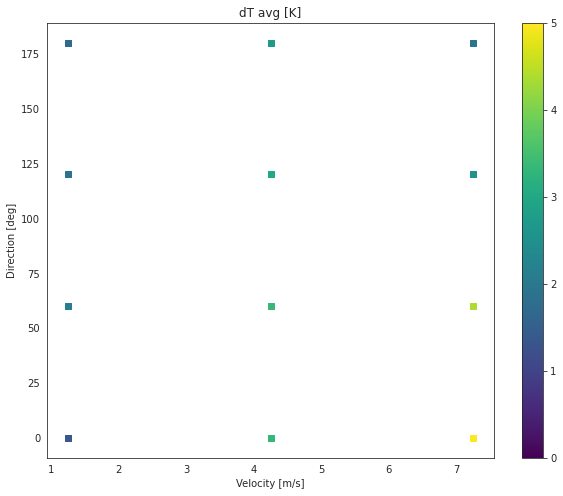

In [5]:
X1_obs = [float(i) for i in avg_temp.columns.tolist()]
X2_obs = [float(i) for i in avg_temp.index.tolist()]
x1, x2 = np.meshgrid(X1_obs, X2_obs)
x11 = sum(x1.tolist(), [])
x22 = sum(x2.tolist(), [])
# x1, x2 = np.meshgrid(np.linspace(0,360,nx1), np.linspace(0,8,nx2))
# X = np.concatenate([x1.reshape(nx1*nx2, 1), x2.reshape(nx1*nx2, 1)], 1)

# X1_obs = chiller_temp.columns.tolist()
# X2_obs = chiller_temp.index.tolist()
y_obs = sum(avg_temp.values.tolist(), [])

with sns.axes_style("white"):
    plt.figure(figsize=(10,8))
    plt.scatter(x11, x22, c=y_obs, marker='s', cmap=plt.cm.viridis, vmin=0, vmax=5)
    plt.xlabel("Velocity [m/s]")
    plt.ylabel("Direction [deg]")
    plt.title("dT avg [K]")
    plt.colorbar()

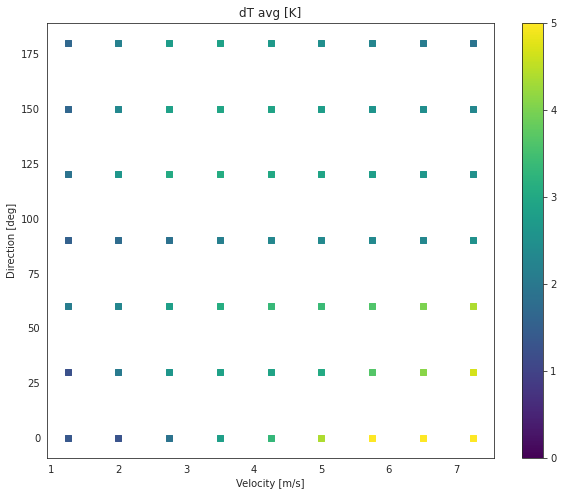

In [6]:
X1_obs_1 = [float(i) for i in avg_temp_1.columns.tolist()]
X2_obs_1 = [float(i) for i in avg_temp_1.index.tolist()]
x1_1, x2_1 = np.meshgrid(X1_obs_1, X2_obs_1)
x11_1 = sum(x1_1.tolist(), [])
x22_1 = sum(x2_1.tolist(), [])
# x1, x2 = np.meshgrid(np.linspace(0,360,nx1), np.linspace(0,8,nx2))
# X = np.concatenate([x1.reshape(nx1*nx2, 1), x2.reshape(nx1*nx2, 1)], 1)

# X1_obs = chiller_temp.columns.tolist()
# X2_obs = chiller_temp.index.tolist()
y_obs_1 = sum(avg_temp_1.values.tolist(), [])

with sns.axes_style("white"):
    plt.figure(figsize=(10,8))
    plt.scatter(x11_1, x22_1, c=y_obs_1, marker='s', cmap=plt.cm.viridis, vmin=0, vmax=5)
    plt.xlabel("Velocity [m/s]")
    plt.ylabel("Direction [deg]")
    plt.title("dT avg [K]")
    plt.colorbar()

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

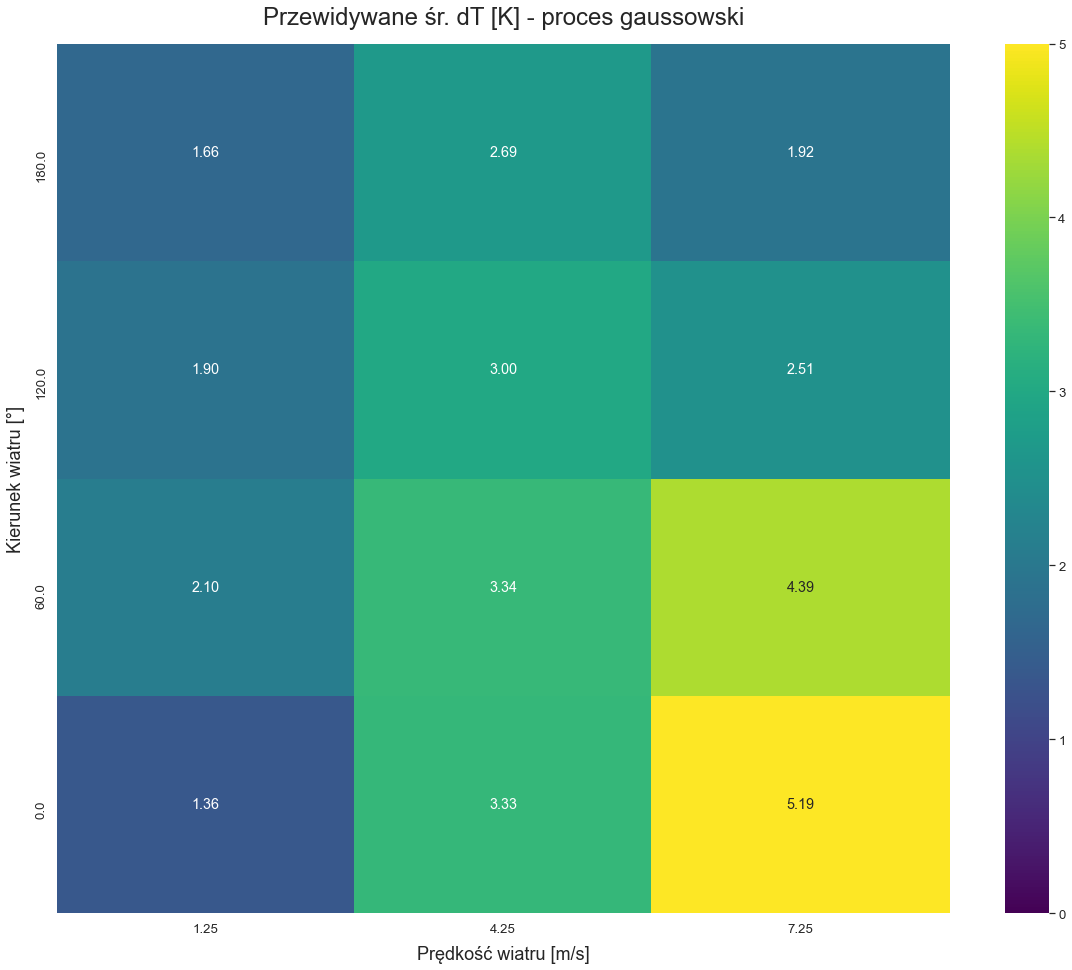

In [7]:
dT = np.reshape(y_obs, (len(X2_obs), len(X1_obs)))

plt.figure(figsize=(20,16))
sns.set(font_scale=1.2)
ax = sns.heatmap(dT, vmin=0, vmax=5, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(avg_temp.index)
ax.set_xticklabels(avg_temp.columns)
ax.set_title('Przewidywane śr. dT [K] - proces gaussowski', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)

In [8]:
X_obs = np.concatenate([x1.reshape(len(x1)*len(x1[0]), 1), x2.reshape(len(x2)*len(x2[0]), 1)], axis=1)

In [9]:
X_obs_1 = np.concatenate([x1_1.reshape(len(x1_1)*len(x1_1[0]), 1), x2_1.reshape(len(x2_1)*len(x2_1[0]), 1)], axis=1)

In [10]:
RANDOM_SEED = 42
CHAINS = 4

In [11]:
with pm.Model() as model_2:
    
    #l1_2 = pm.Normal("l1", mu=5, sigma=2)
    #l1_2 = pm.ChiSquared("l1", nu=6)
    #l1_2 = pm.ExGaussian("l1", mu=5, sigma=2, nu=1)
    #l1_2 = pm.Gamma("l1", mu=5, sigma=3)
    l1_2 = pm.Rice("ls", nu=4, sigma=3)
    #l1_2 = pm.Normal("ls", mu=0, sigma=5)
    #l2_2 = pm.ChiSquared("l2", nu=15)
    #l2_2 = pm.ExGaussian("l2", mu=40, sigma=10, nu=1)
    #l2_2 = pm.Gamma("l2", mu=30, sigma=10)
    l2_2 = pm.Rice("ld", nu=180, sigma=70)
    #l2_2 = pm.Normal("ld", mu=0, sigma=40)
    #sf_2 = pm.HalfCauchy("sf", 2)
    #sf_2 = pm.HalfStudentT("sf", sigma=3, nu=1)
    sf_2 = pm.Rice("sf", nu=5, sigma=2)
    sn_2 = pm.HalfNormal("sn", 0.6)

    #M = pm.gp.mean.Constant([2.5])
    M_2 = pm.gp.mean.Zero()
    K_2 = pm.gp.cov.ExpQuad(2, [l1_2, l2_2]) * sf_2**2
    
    gp_chillers_2 = pm.gp.Marginal(mean_func=M_2, cov_func=K_2)
    obs_2 = gp_chillers_2.marginal_likelihood("obs_2", X=X_obs, y=y_obs, noise=sn_2)

In [12]:
with pm.Model() as model_1:
    
    #l1_2 = pm.Normal("l1", mu=5, sigma=2)
    #l1_2 = pm.ChiSquared("l1", nu=6)
    #l1_2 = pm.ExGaussian("l1", mu=5, sigma=2, nu=1)
    #l1_2 = pm.Gamma("l1", mu=5, sigma=3)
    l1_1 = pm.Rice("ls_1", nu=3, sigma=1)
    #l1_2 = pm.Normal("ls", mu=0, sigma=5)
    #l2_2 = pm.ChiSquared("l2", nu=15)
    #l2_2 = pm.ExGaussian("l2", mu=40, sigma=10, nu=1)
    #l2_2 = pm.Gamma("l2", mu=30, sigma=10)
    l2_1 = pm.Rice("ld_1", nu=30, sigma=2)
    #l2_2 = pm.Normal("ld", mu=0, sigma=40)
    #sf_2 = pm.HalfCauchy("sf", 2)
    #sf_2 = pm.HalfStudentT("sf", sigma=3, nu=1)
    sf_1 = pm.Rice("sf_1", nu=0, sigma=1)
    sn_1 = pm.HalfNormal("sn_1", 0.17)

    #M = pm.gp.mean.Constant([2.5])
    M_1 = pm.gp.mean.Zero()
    K_1 = pm.gp.cov.ExpQuad(2, [l1_1, l2_1]) * sf_1**2
    
    gp_chillers_1 = pm.gp.Marginal(mean_func=M_1, cov_func=K_1)
    obs_1 = gp_chillers_1.marginal_likelihood("obs_1", X=X_obs_1, y=y_obs_1, noise=sn_1)

In [13]:
with model_2:
    gp_trace_2 = pm.sample(1000, tune=2000, cores=8, chains=CHAINS, random_seed=RANDOM_SEED, target_accept=0.95)

WARNING (theano.tensor.opt): Optimization Warning: The Op i0e does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.opt): Optimization Warning: The Op i1e does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [sn, sf, ld, ls]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 44 seconds.


In [14]:
with model_1:
    gp_trace_1 = pm.sample(1000, tune=2000, cores=8, chains=CHAINS, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [sn_1, sf_1, ld_1, ls_1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 42 seconds.


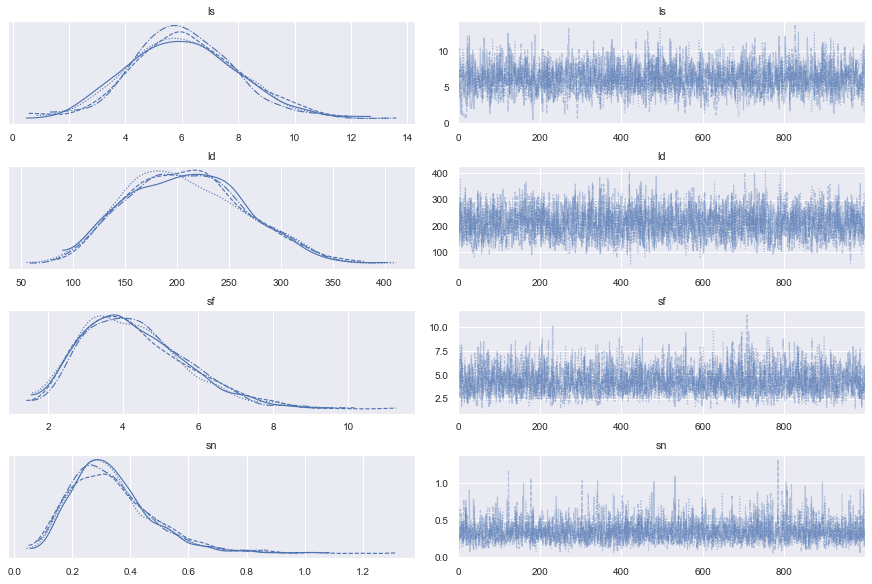

In [15]:
az.plot_trace(gp_trace_2, var_names=['ls', 'ld', 'sf', 'sn']);

array([<AxesSubplot:title={'center':'ls'}>,
       <AxesSubplot:title={'center':'ld'}>,
       <AxesSubplot:title={'center':'sf'}>,
       <AxesSubplot:title={'center':'sn'}>], dtype=object)

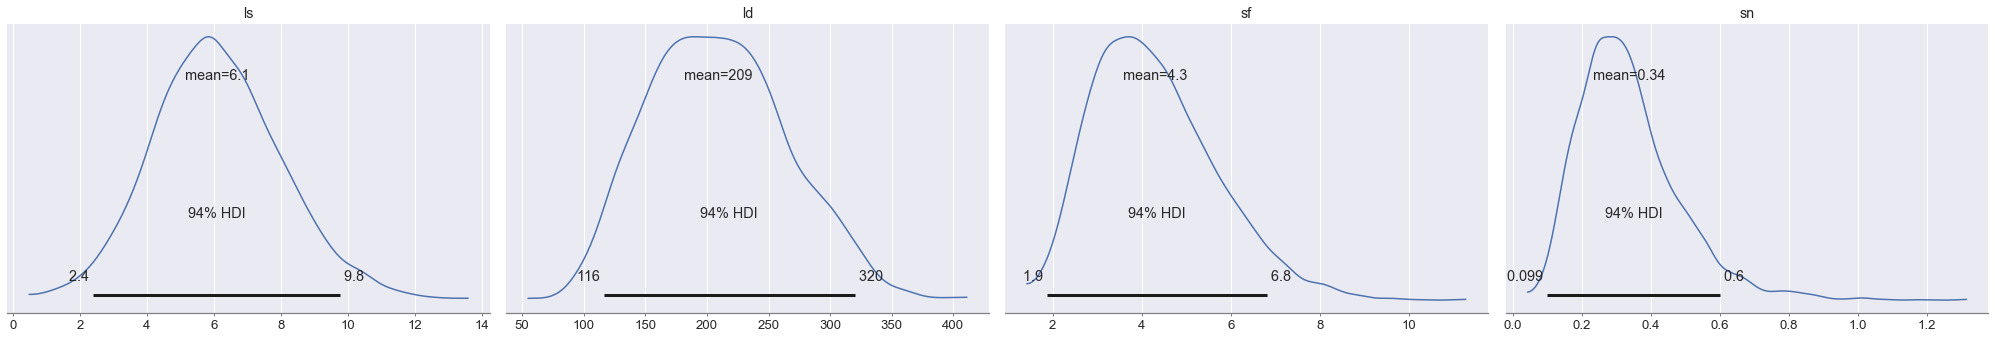

In [16]:
az.plot_posterior(gp_trace_2)

In [17]:
az.summary(gp_trace_2, round_to=3, var_names=['ls', 'ld', 'sf', 'sn'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ls,6.104,1.946,2.383,9.771,0.041,0.029,2166.311,1342.066,1.002
ld,209.232,56.279,116.165,319.952,1.154,0.816,2275.966,2332.307,1.001
sf,4.292,1.385,1.883,6.808,0.026,0.019,2694.391,2410.431,1.001
sn,0.336,0.147,0.099,0.601,0.003,0.002,2358.905,2210.736,1.002


In [18]:
loo_2 = az.loo(gp_trace_2, model_2)
loo_2.loo

-17.034855064955735

In [19]:
nv = 18
nd = 14
ws = np.linspace(0.5, 10, nv)
wd = np.linspace(10, 170, nd)
t1, t2 = np.meshgrid(ws, wd)
T = np.concatenate([t1.reshape(len(t1)*len(t1[0]), 1), t2.reshape(len(t2)*len(t2[0]), 1)], axis=1)

In [20]:
with model_2:

    f_pred_2 = gp_chillers_2.conditional('f_pred_2', T)
    
    samples_2 = pm.sample_posterior_predictive([gp_trace_2], var_names=['f_pred_2'], random_seed=RANDOM_SEED, samples=100)

In [21]:
with model_1:

    f_pred_1 = gp_chillers_1.conditional('f_pred_1', T)
    
    samples_1 = pm.sample_posterior_predictive([gp_trace_1], var_names=['f_pred_1'], random_seed=RANDOM_SEED, samples=100)

In [22]:
s_2 = samples_2['f_pred_2'].mean(axis=0).reshape(nd, nv)
sd_2 = samples_2['f_pred_2'].std(axis=0).reshape(nd, nv)
s_1 = samples_1['f_pred_1'].mean(axis=0).reshape(nd, nv)
sd_1 = samples_1['f_pred_1'].std(axis=0).reshape(nd, nv)

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

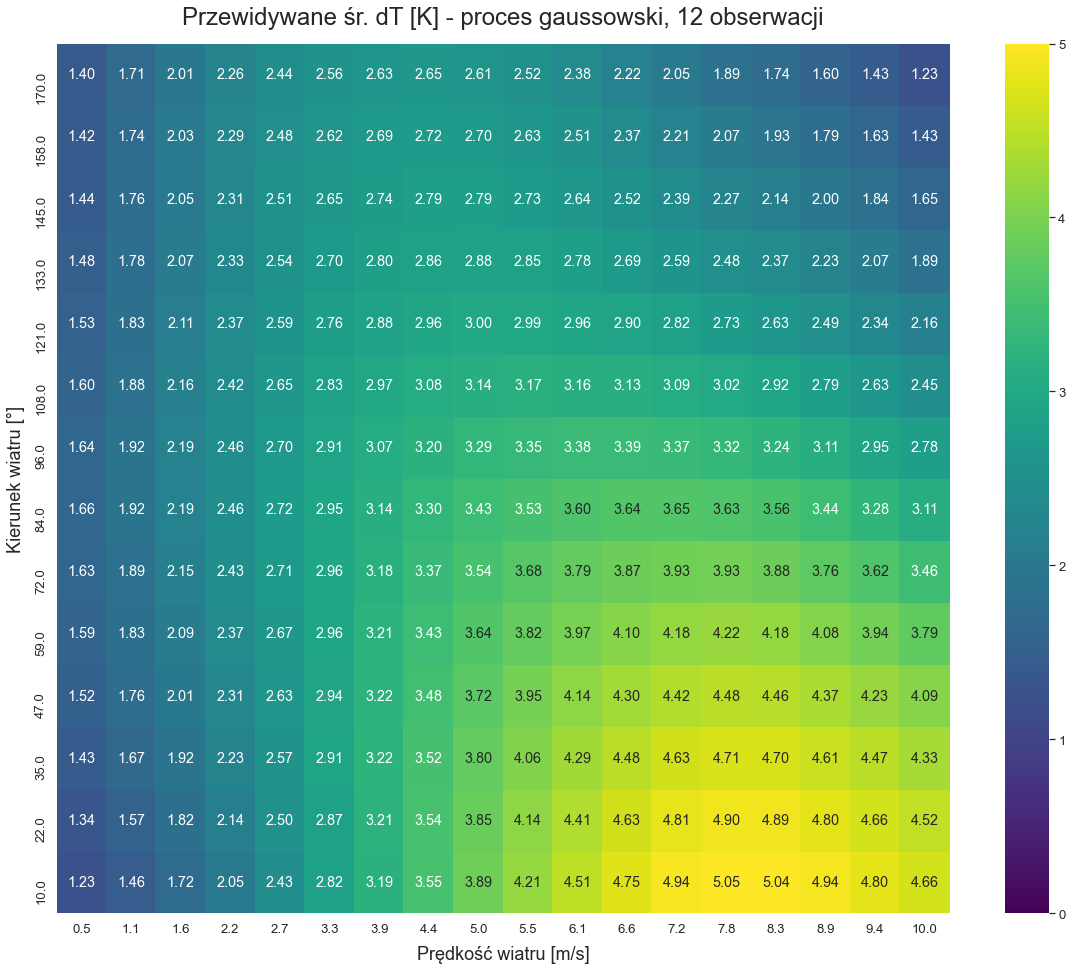

In [23]:
plt.figure(figsize=(20,16))
sns.set(font_scale=1.2)
ax = sns.heatmap(s_2, vmin=0, vmax=5, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Przewidywane śr. dT [K] - proces gaussowski, 12 obserwacji', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

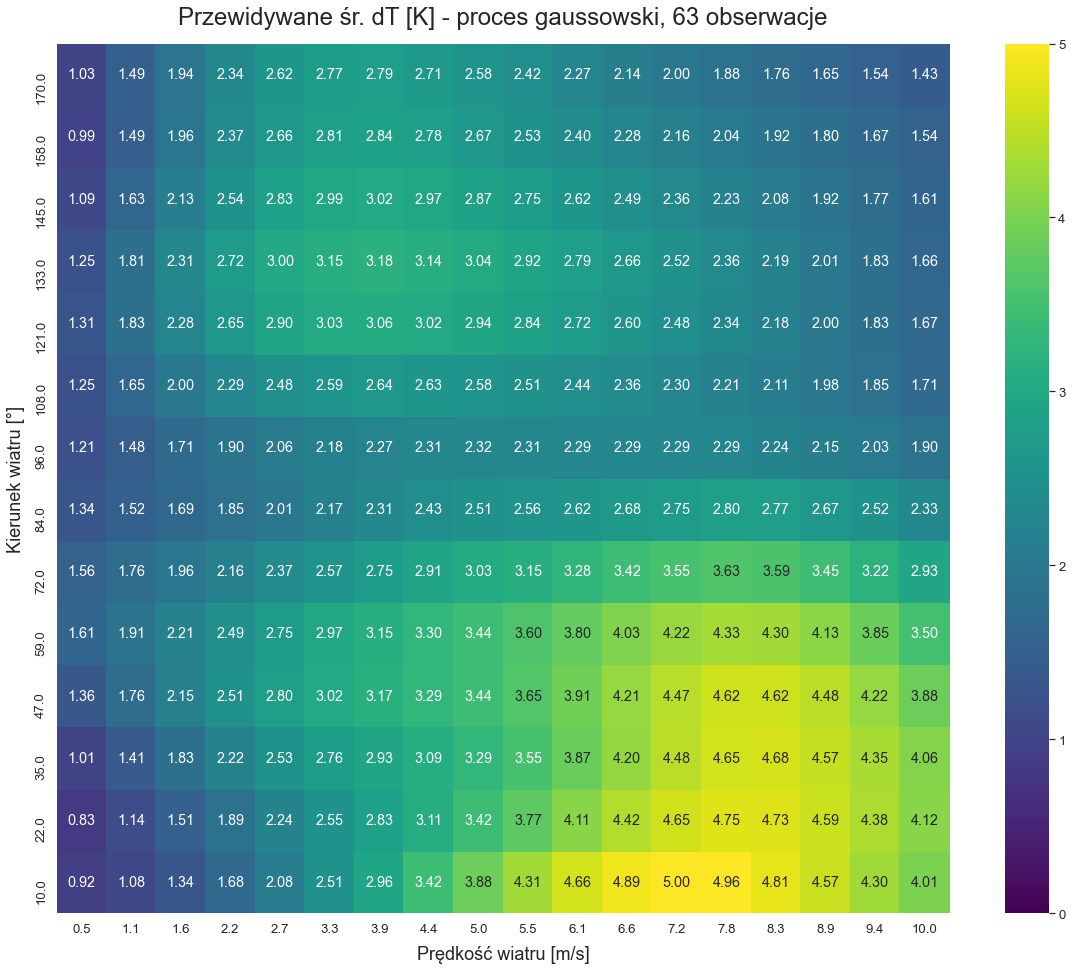

In [24]:
plt.figure(figsize=(20,16))
sns.set(font_scale=1.2)
ax = sns.heatmap(s_1, vmin=0, vmax=5, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Przewidywane śr. dT [K] - proces gaussowski, 63 obserwacje', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)

In [25]:
diff = s_2 - s_1
diff

array([[ 0.31087018,  0.37848637,  0.38022658,  0.36511641,  0.34920504,
         0.30835803,  0.23053249,  0.12576583,  0.00640437, -0.10055266,
        -0.1562055 , -0.14046763, -0.05584553,  0.0811205 ,  0.23045732,
         0.36744302,  0.50729204,  0.648769  ],
       [ 0.50785388,  0.42211206,  0.31160453,  0.25104395,  0.2655598 ,
         0.32340451,  0.3859534 ,  0.42938438,  0.42999798,  0.37859311,
         0.29714119,  0.21404892,  0.15694394,  0.14475272,  0.16257829,
         0.20200005,  0.28489295,  0.40524692],
       [ 0.4294669 ,  0.25696963,  0.08938252,  0.0072996 ,  0.03608669,
         0.14654996,  0.29130856,  0.42802781,  0.51161563,  0.50778097,
         0.42289758,  0.28772923,  0.15170655,  0.06167111,  0.02358843,
         0.03784995,  0.1246739 ,  0.27163913],
       [ 0.15557757,  0.00158109, -0.13835795, -0.2023462 , -0.17570594,
        -0.07844477,  0.05504578,  0.18999473,  0.28576035,  0.30124461,
         0.23032273,  0.09746822, -0.04393264, -0.136

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

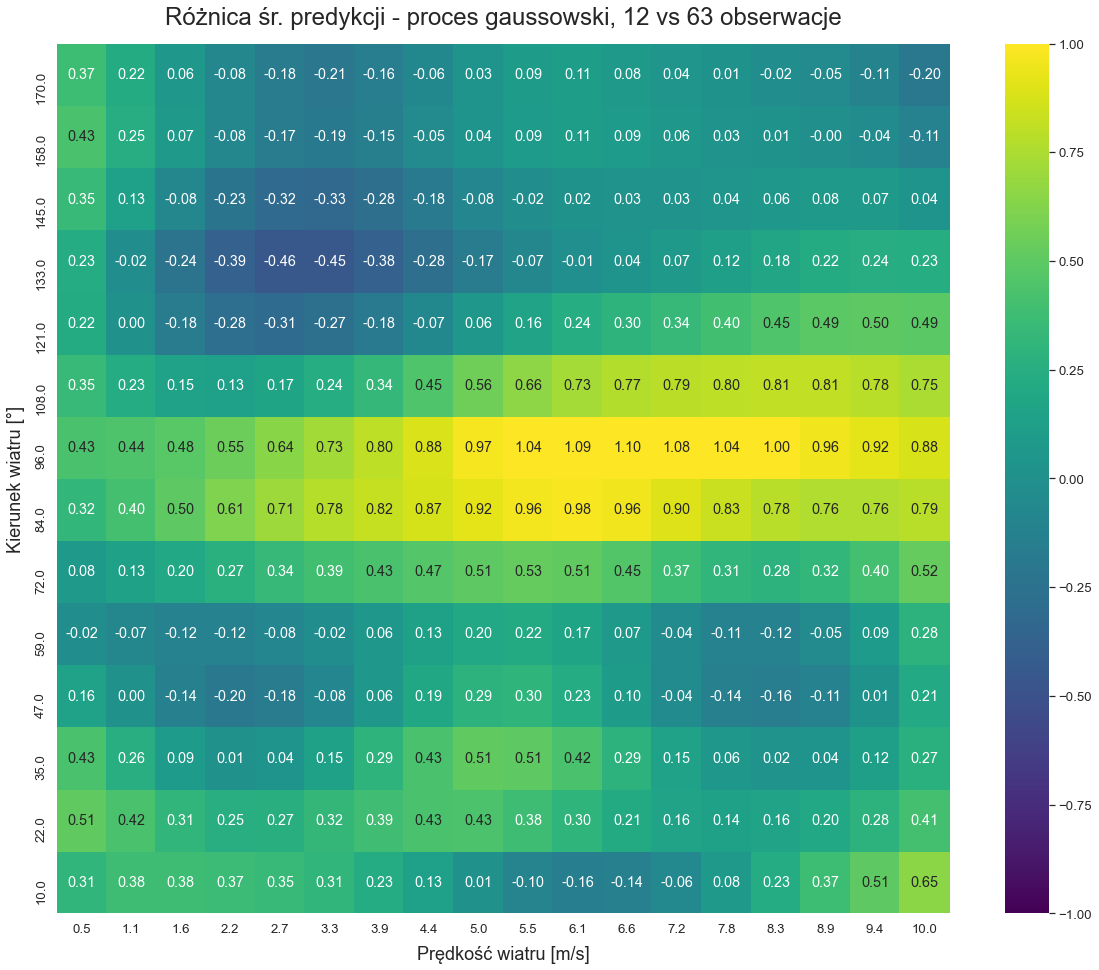

In [36]:
plt.figure(figsize=(20,16))
sns.set(font_scale=1.2)
ax = sns.heatmap(diff, vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Różnica śr. predykcji - proces gaussowski, 12 vs 63 obserwacje', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)

In [42]:
diff.mean()

0.23835080641104697

In [27]:
nv_2 = 9
nd_2 = 7
ws_2 = np.linspace(1.25, 7.25, nv_2)
wd_2 = np.linspace(0, 180, nd_2)
t1_2, t2_2 = np.meshgrid(ws_2, wd_2)
T_2 = np.concatenate([t1_2.reshape(len(t1_2)*len(t1_2[0]), 1), t2_2.reshape(len(t2_2)*len(t2_2[0]), 1)], axis=1)

In [28]:
with model_2:

    f_pred_3 = gp_chillers_2.conditional('f_pred_3', T_2)
    
    samples_3 = pm.sample_posterior_predictive([gp_trace_2], var_names=['f_pred_3'], random_seed=RANDOM_SEED, samples=100)

In [29]:
s_3 = samples_3['f_pred_3'].mean(axis=0).reshape(nd_2, nv_2)
sd_3 = samples_3['f_pred_3'].std(axis=0).reshape(nd_2, nv_2)

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

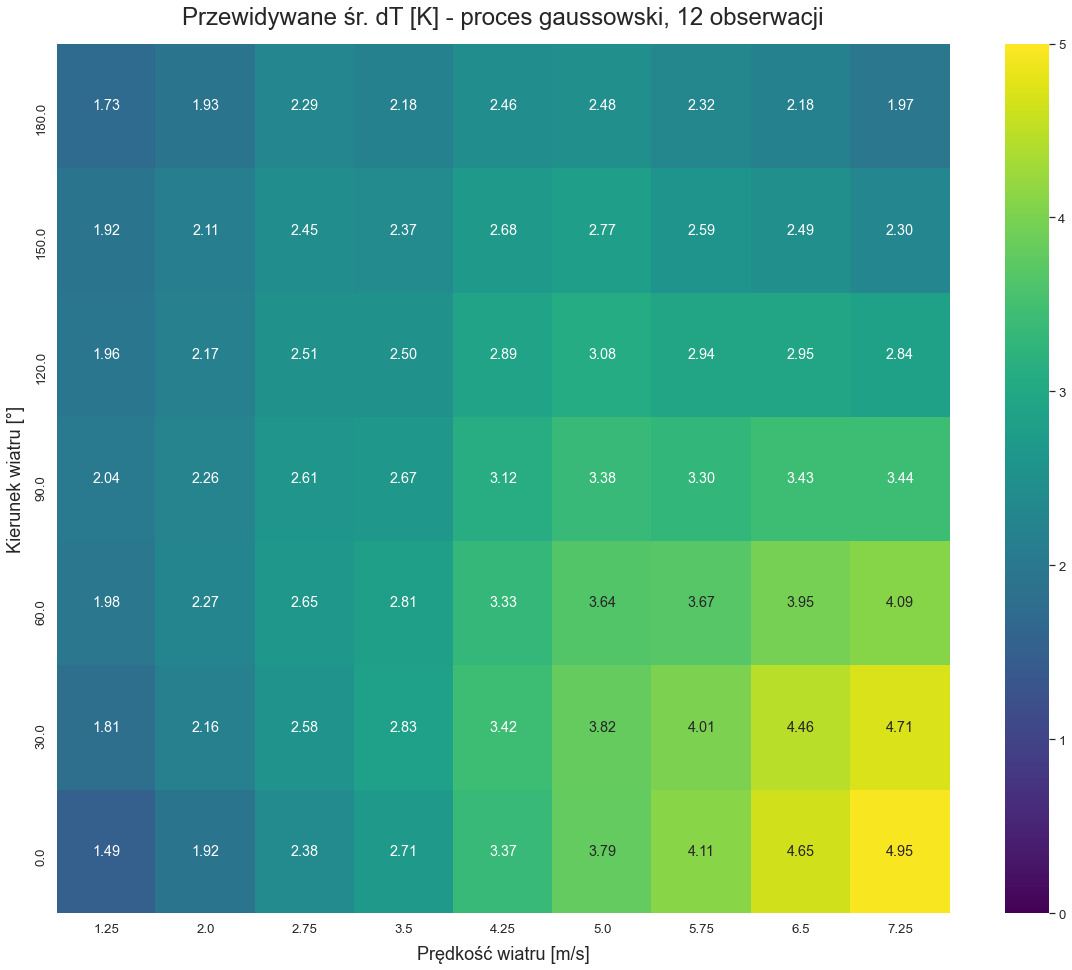

In [30]:
plt.figure(figsize=(20,16))
sns.set(font_scale=1.2)
ax = sns.heatmap(s_3, vmin=0, vmax=5, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd_2.round(1))
ax.set_xticklabels(ws_2.round(2))
ax.set_title('Przewidywane śr. dT [K] - proces gaussowski, 12 obserwacji', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)

In [31]:
err = s_3 - np.reshape(y_obs_1, (len(X2_obs_1), len(X1_obs_1)))

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

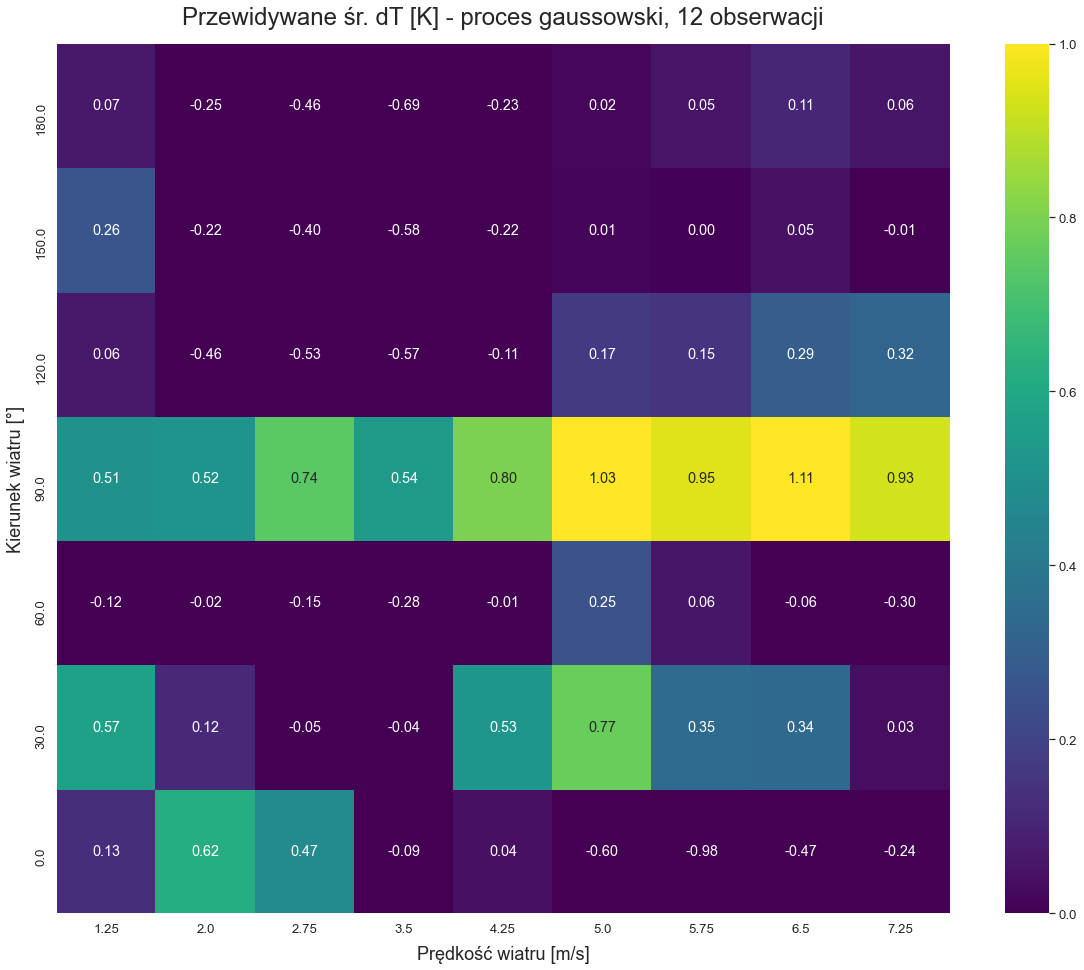

In [32]:
plt.figure(figsize=(20,16))
sns.set(font_scale=1.2)
ax = sns.heatmap(err, vmin=0, vmax=1, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd_2.round())
ax.set_xticklabels(ws_2.round(2))
ax.set_title('Przewidywane śr. dT [K] - proces gaussowski, 12 obserwacji', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

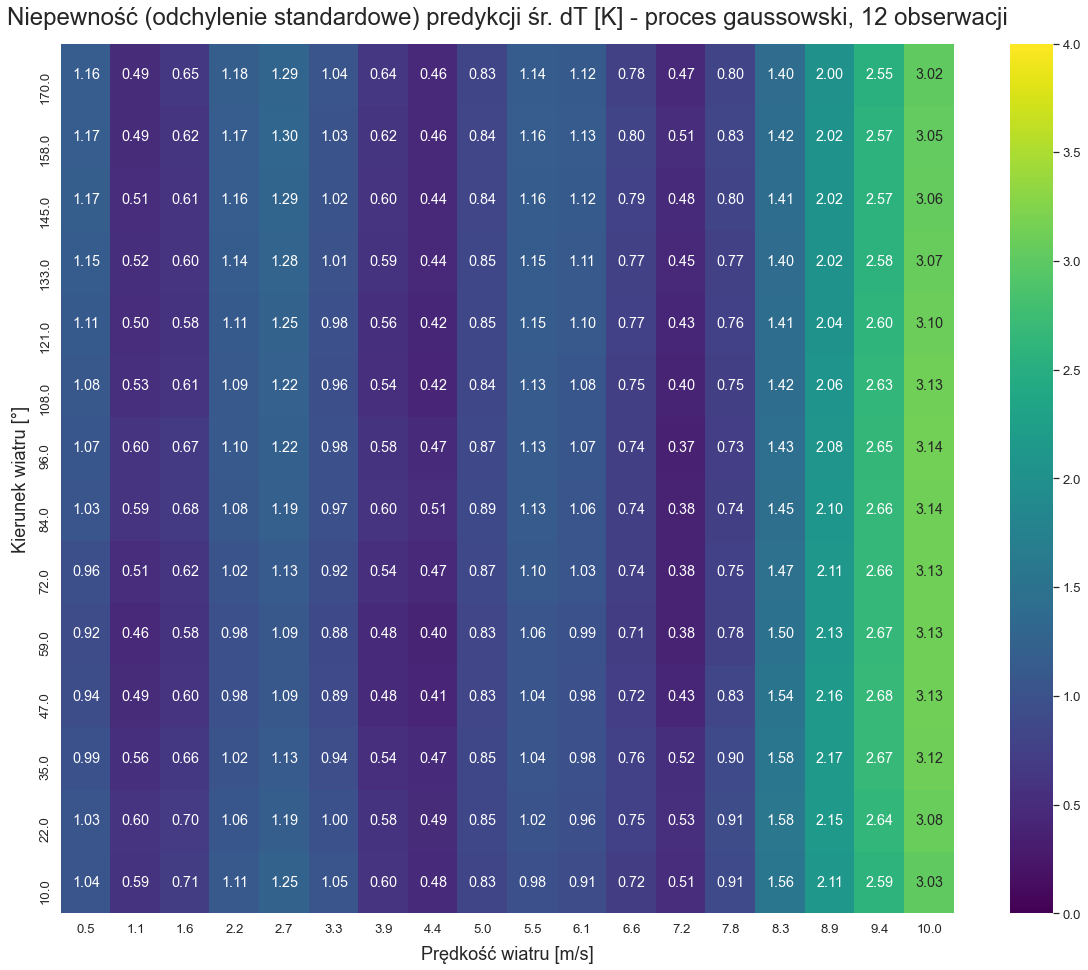

In [38]:
plt.figure(figsize=(20,16))
ax = sns.heatmap(sd_2, vmin=0, vmax=4, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Niepewność (odchylenie standardowe) predykcji śr. dT [K] - proces gaussowski, 12 obserwacji', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)